In [13]:
# ----------------------------------------------------------------
# IoT Netprofiler
# Licensed under The MIT License [see LICENSE for details]
# Written by Luca Maiano - https://www.linkedin.com/in/lucamaiano/
# ----------------------------------------------------------------

# Data Exploration

In this notebook we plot useful informations like the distrubution of standard values, outliers and tumbling windows. The data that we analyse come from a set of experiments on IoT devices that we ran in a simulator. We want to find out if it is possible to detect network attacks in an Industrial Internet of Things scenario analyzing data coming from ICMP (a network layer protocol) messages. 

The set of experiments contains *Black Hole* and *Grey Hole attacks* and *normal behaviour* examples. Nodes in an experiment run RPL protocol, thus we expect that an attacked node will affect trasmissions of its neighbors. Each experiment is executed in a window of **200 pings per node**.

Number of malicious nodes are quite few than number of benign nodes. This is typical in anomaly-detection problems. Even more, we realized that the malicious nodes usually has more or less important effects on the entire network. Thus all nodes belonging to an attacked network have been labeled as attacked.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import matplotlib.pyplot as plt
import os
#import warnings 
#warnings.filterwarnings('ignore')

from lib.utils import trace_processing
from lib.analysis import trace_classification
from lib.analysis import trace_statistics
from lib.visualization import data_visualization

Using TensorFlow backend.


We have 2 sets of experiments:
1. *9 nodes* examples containing grids and random topologies;
2. *16 nodes* examples containing grids and random topologies.

In [ ]:
exp_9_nodes = trace_processing.import_trace('data/experiments/cooja3-9nodes/traces/', 'traces.csv')
exp_16_nodes = trace_processing.import_trace('data/experiments/cooja3-16nodes/traces/', 'traces.csv')

experiments = exp_9_nodes + exp_16_nodes

We start the analysis plotting the distribution of Round Trip Times (RTTs) of each experiment.

In [ ]:
for experiment in experiments:
    topology = experiment[0].split('/')[2]
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    # Save plots in data/figures/rtt_distributions
    data_visualization.rtt_distrubution_of_nodes(nodes, packets_node, 1000, 0.018, topology, experiment[1])

RTTs can vary over time, thus it could be useful to study them to find [3]:
1. *autocorrelation* that hilights similarity between observations as function of time lag between them;
2. *seasonability*, i.e. periodic fluctuations;
3. *trends*;
4. *stationarity* that describes variations of statistical properties over time.
Those informations could help us to study trends in data.

Let us start analyzing the autocorrelation. This is also helful to derive seasonability. We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables. The **Pearson’s correlation coefficient** is a number between *\-1 and 1* that describes a negative or positive correlation respectively. A value of zero indicates no correlation. We can calculate the correlation for time series observations with observations with previous time steps, called *lags*. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF.

In [5]:
for experiment in experiments:
    topology = experiment[0].split('/')[2]
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    # Save plots in data/figures/autocorrelations
    data_visualization.rtt_autocorrelation_of_nodes(nodes, packets_node, 100, -0.8, 0.8, topology, experiment[1])

The results above suggest that RTTs do not follow periodic fluctuations. It could still be useful to search for trends. We can use **exponential smoothing**. Similarly to moving average, it can be used to identify trends in data. A different weight is assigned to each observation. *Less importance* is given to observations as we move further from the present through a smoothing factor.

In [ ]:
for experiment in experiments:
    topology = experiment[0].split('/')[2]
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    # Save plots in data/figures/exponential_smoothing
    data_visualization.rtt_exponential_smoothing_of_nodes(nodes, packets_node, 0.005, 200, 1000, topology, experiment[1])

The results obtained above do not show particular trends, suggesting that the **RTT time series are stationary**. 

Let us make strong assumptions about our data computing **Advanced Dickey-Fuller test** [4]. This is a statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

1. *Null Hypothesis (H0)*: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
2. *Alternate Hypothesis (H1)*: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [7]:
adftest = pd.DataFrame(columns=['topology', 'experiment', 'node', 'adf statistic', 'p-value',
      'critical values 1%', 'critical-values 5%', 'critical-values 10%', 'stationary'])

for experiment in experiments:
    topology = experiment[0].split('/')[2]
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    # Save plots in data/figures/exponential_smoothing
    adftest = adftest.append(trace_statistics.node_adftest(packets_node, topology.split('cooja3-')[1], experiment[1]))
    
adftest = adftest.reset_index(drop=True)
adftest.head(5)

,topology,experiment,node,adf statistic,p-value,critical values 1%,critical-values 5%,critical-values 10%,stationary
0,9nodes,rnd_1bh-9_2019-02-14_15:15_,aaaa::212:7407:7:707:,-4.472401,2.204957e-04,-3.468062,-2.878106,-2.575602,True
1,9nodes,rnd_1bh-9_2019-02-14_15:15_,aaaa::212:7409:9:909:,-13.716352,1.210844e-25,-3.465244,-2.876875,-2.574945,True
2,9nodes,grid9_normal_2019-02-13_17:05_,aaaa::212:7404:4:404:,-5.356998,4.167696e-06,-3.478648,-2.882722,-2.578065,True
3,9nodes,grid9_normal_2019-02-13_17:05_,aaaa::212:7405:5:505:,-10.077412,1.213480e-17,-3.467845,-2.878012,-2.575551,True
4,9nodes,grid9_normal_2019-02-13_17:05_,aaaa::212:7407:7:707:,-5.030455,1.931067e-05,-3.475325,-2.881275,-2.577293,True


In [8]:
print('Percentage of stationary processes: {:f}%'.format(np.count_nonzero(adftest['stationary']) / len(adftest['stationary'])*100))

Percentage of stationary processes: 79.772727%


Advanced Dickey-Fuller test confirm that the hypothesis that **RTTs time series are stationary**, at least for *> 79% of nodes*. 

Starting from these results, a **log transform** can be used to flatten out *non-stationary nodes* back to a linear relationship. This could help learning algorithms, in fact stationary time series can be easier to model.



# Feature Extraction

Now that we analyzed the distribution of RTTs, we can start to select relevant features. Starting from RTTs and sequence numbers, we consider the following features:
1. the id of the **experiment**;
2. **node** id;
3. **tr_time**, i.e. the sum of RTTs of a node during the experiment in a fixed window of packets;
4. **pckt_count** number of packets that have been received in a fixed window of packets;
5. **mean** of the RTT;
6. **var** of the RTT;
7. **hop** of the node during the experiment;
8. **min** value of the RTT;
9. **max** value of the RTT;
10. **loss**, i.e. number of lost packets in a fixed window;
11. number of **outliers** in a fixed window.
12. the **label** indicating if a node belongs to an attacked network or not.



# Scenarios

From now on, we consider two different experimental scenarios:
1. we want to detect if a network has been attacked or not, without asking what kind of attacks are in progress; thus we label the dataset as **normal** (0) and **attacked** (1);
2. we want to detect the attack that has been performed (if any), so we introduce the follwing classes: **normal** (0), **grey hole** (1) and **black hole** (2).


# Experiment 1: Attacked vs Normal Behaviour

Let us start extracting features from the first scenario.

In [55]:
data = None
n_classes = 2

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
            
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7408:8:808:,9nodes/grid9_1bh-5_2019-02-13_15:31_,1030.473217,181,5.693222,0.138414,4,5.017280,6.673298,19.0,11,1
1,aaaa::212:7404:4:404:,9nodes/grid9_normal_2019-02-13_22:23_,908.439353,195,4.658663,0.176038,2,4.053523,6.184149,5.0,11,0
2,aaaa::212:7407:7:707:,9nodes/grid9_normal_2019-02-13_18:51_,968.012123,181,5.348133,0.165155,3,4.941642,7.423568,19.0,10,0
3,aaaa::212:7406:6:606:,9nodes/grid_1gh-9_2019-02-15_19:19_,703.321849,148,4.752175,0.207244,2,4.136765,6.156979,52.0,9,1
4,aaaa::212:740e:e:e0e:,16nodes/grid_normal_2019-02-26_10:53_,851.823332,127,6.707270,0.136387,5,5.978886,7.621685,73.0,7,0


Data resulting from different networks could have different mean and variance due to their different network topologies. This could reduce the learning rate of machine learning and deep learning algorithms. Thus we apply **feaure normalization**.

In [56]:
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])
norm_data.head(5)

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7408:8:808:,9nodes/grid9_1bh-5_2019-02-13_15:31_,0.885857,0.903553,0.551169,0.096433,0.75,0.584472,0.446894,0.096447,0.6875,1
1,aaaa::212:7404:4:404:,9nodes/grid9_normal_2019-02-13_22:23_,0.779108,0.974619,0.259950,0.131021,0.25,0.276820,0.332001,0.025381,0.6875,0
2,aaaa::212:7407:7:707:,9nodes/grid9_normal_2019-02-13_18:51_,0.831219,0.903553,0.454029,0.121016,0.50,0.560327,0.623121,0.096447,0.6250,0
3,aaaa::212:7406:6:606:,9nodes/grid_1gh-9_2019-02-15_19:19_,0.599682,0.736041,0.286272,0.159708,0.25,0.303393,0.325619,0.263959,0.5625,1
4,aaaa::212:740e:e:e0e:,16nodes/grid_normal_2019-02-26_10:53_,0.729583,0.629442,0.836614,0.094571,1.00,0.891438,0.669655,0.370558,0.4375,0


## Feature Selection

Some features could be more important than others, so if we select the right set of features, this could help to improve the results given by a learning classifier. 

Let's start plotting the *correlation matrix* of features. It will help us to understand which features are more importantly related to classes. We use **Pearson Coefficient**, that assign a value within 1 (i.e. *positive correlation*) and -1 (*negative correlation*).

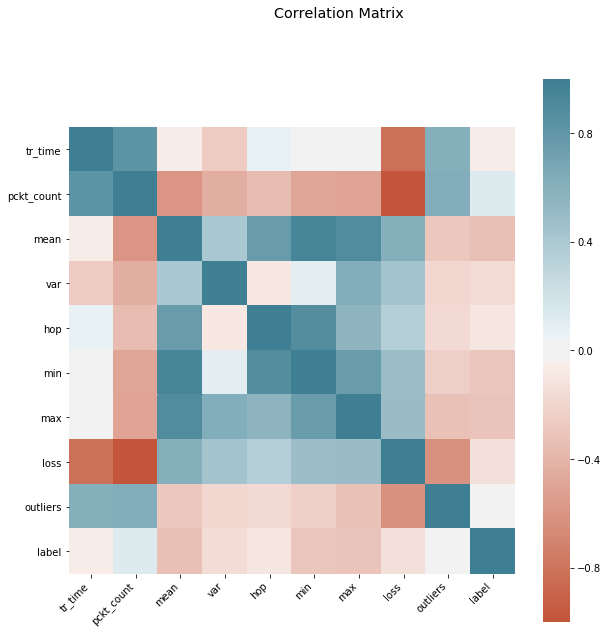

In [57]:
data_visualization.plot_correlation_matrix(norm_data[norm_data.columns[2:]], '2_classes_dataset')

The matrix above shows that apart from *outliers*, all features are more or less negatively correlated to the class. This result suggests that a model could learn to discriminate between *attacked* and *normal* networks.


Following the approach proposed by Furkan Yusuf Yavuz, Devrim Ünal and Ensar Gul in [1], we can use **RandomForestClassifier** to iteratively select most relevant features. In fact, as they suggest, if a feature importance is high it dilutes the effect of the others and may cause overfitting, while less important could slow down (or even deviate) the learning process.

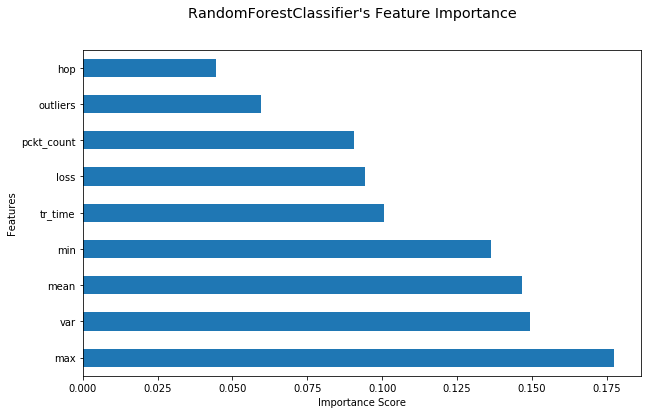

In [58]:
data_visualization.random_forests_features_selection(norm_data[norm_data.columns[2:]], '2_classes_dataset')

It could be useful to visualize the dataset in a plot. For this purpose we can use PCA to project the set of data points in a three dimensional space.

In [59]:
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_pca = trace_classification.pca_transformation(X, n_components=6)
X_pca.head()

,0,1,2,3,4,5
0,0.120610,-0.475265,-0.103178,0.144087,0.056229,0.044015
1,-0.464884,-0.155741,0.013294,0.118128,0.030871,-0.019526
2,0.022068,-0.310833,0.076232,0.043990,-0.008487,-0.112874
3,-0.257853,0.174261,-0.089547,0.132923,0.016083,-0.013046
4,0.807128,-0.307287,-0.178715,0.034507,-0.028508,0.026528


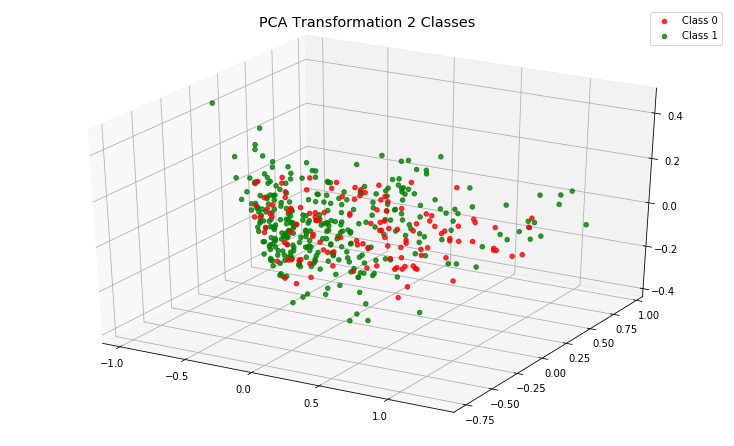

In [60]:
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='PCA_2classes')

# Experiment 2: Normal Behaviour vs Grey Hole vs Black Hole Attack

Now we split the dataset in 3 classes as explained above. We start this data exploration importing the data and normalizing features.

In [76]:
data = None
n_classes = 3

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
            
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])
norm_data.head(5)

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:740f:f:f0f:,16nodes/grid_normal_2019-02-26_10:53_,0.778013,0.700508,0.759679,0.164909,0.75,0.818179,0.803357,0.299492,0.3125,0
1,aaaa::212:740a:a:a0a:,16nodes/grid_1bh-9_2019-02-20_00:30_,0.916938,0.959391,0.511446,0.027915,0.75,0.618528,0.383540,0.040609,0.7500,2
2,aaaa::212:7406:6:606:,9nodes/rnd_1bh-2_2019-02-14_15:38_,0.773224,0.984772,0.237025,0.054062,0.25,0.275709,0.365354,0.015228,0.3125,2
3,aaaa::212:7406:6:606:,9nodes/grid9_1bh-6_2019-02-13_19:15_,0.825502,0.984772,0.322421,0.050439,0.25,0.363627,0.369519,0.015228,0.4375,2
4,aaaa::212:740b:b:b0b:,16nodes/grid_normal_2019-02-26_10:29_,0.763657,0.685279,0.765573,0.347470,0.75,0.728371,0.839155,0.314721,0.3750,0


## Feature Selection

Here we plot the correlation matrix using 3 classes.

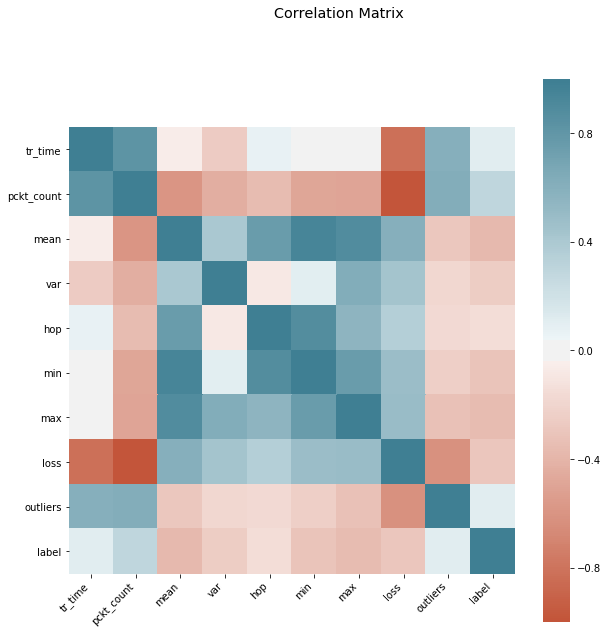

In [77]:
data_visualization.plot_correlation_matrix(norm_data[norm_data.columns[2:]], '3_classes_dataset')

The matrix is similar to the one we get for 2 classes, but some features have a slightly stronger correlation.

Let us run RandomForest feature selection again.

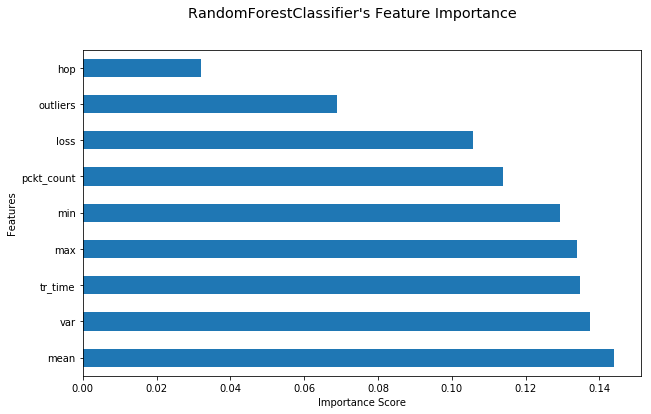

In [78]:
data_visualization.random_forests_features_selection(norm_data[norm_data.columns[2:]], '3_classes_dataset')

Again, we obtained similar results as for 2 classes scenario. We conclude this analysis projecting again the datapoints with a PCA and visualizing the plot.

In [79]:
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_pca = trace_classification.pca_transformation(X, n_components=6)
X_pca.head()

,0,1,2,3,4,5
0,0.640461,-0.217509,0.045299,-0.147833,-0.063849,-0.029158
1,0.041748,-0.572324,-0.157943,0.176979,0.013087,0.035125
2,-0.424311,-0.070393,-0.066119,-0.245040,0.003970,0.001137
3,-0.368903,-0.162062,-0.019112,-0.129640,-0.075126,0.013095
4,0.636964,-0.158631,0.174407,-0.069568,0.073849,0.016118


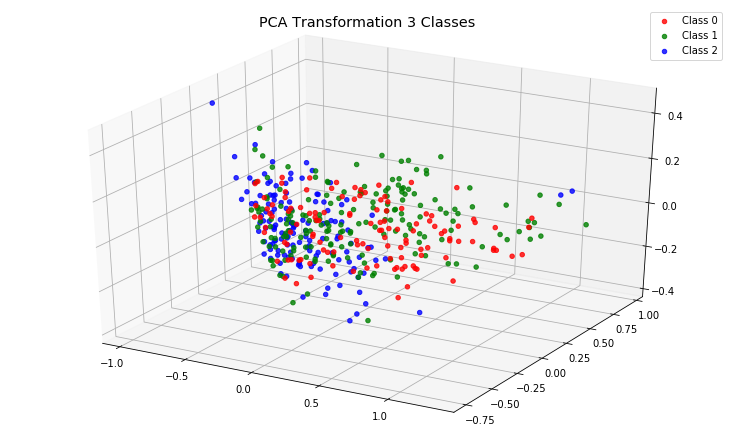

In [80]:
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='PCA_3classes')

# Conclusions

The results above confirm what have been suggested by the correlation matrix. Maximum and minimum values of RTTs, together with mean and variance are the most relevant features. Even more, the number of hops and the anomalous values of a node do not seem to give significant indications on the class to which they belong. 

Next steps will focus on the application of *machine learning* and *deep learning* algorithms will focus on an iterative experimentation in which we will try to identify the best set of features that can be used to extract relevant informations.

# References

1. *Deep Learning for Detection of Routing Attacks in the Internet of Things*, International Journal of Computational Intelligence Systems (2018), by Furkan Yusuf Yavuz, Devrim Ünal and Ensar Gul
2. *Machine Learning in IoT Security:Current Solutions and Future Challenges*, arXiv:1904.05735v1 (Mar 2019), by Fatima Hussain, Rasheed Hussain, Syed Ali Hassan, and Ekram Hossain.
3. *Almost Everything You Need to Know About Time Series*, https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578, by Marco Peixeiro
4. *How to Check if Time Series Data is Stationary with Python*, https://machinelearningmastery.com/time-series-data-stationary-python/, by Jason Brownlee
5. *K-Means Clustering in Python*, https://mubaris.com/posts/kmeans-clustering/, by Mubaris NK
6. *AUC ROC Curve Scoring Function for Multi-class Classification*, https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659, by Eric Plog